In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)

C:\Users\AI-lab\github_repo\neural-network\python\ga.py:197: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9444444444444444, Loss: 0.19492053985595703
Checkpoint 200, Accuracy: 0.9444444444444444, Loss: 0.17937216935334382
Checkpoint 300, Accuracy: 0.9506172839506173, Loss: 0.1790390897680212
Checkpoint 400, Accuracy: 0.9567901234567902, Loss: 0.1643390832123933
Checkpoint 500, Accuracy: 0.9567901234567902, Loss: 0.17096040866993092


In [10]:
print(history)

[{'accuracy': 0.7819314641744548, 'mean_square_error': 3.101993889531005, 'categorical_crossentropy': 0.8121264448789792, 'precision': 0.6728971962616822, 'recall': 0.6728971962616822, 'f1': 0.6728971962616822, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 35, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 88, 'fn_hit': 19}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 16}}}, {'accuracy': 0.8317757009345794, 'mean_square_error': 0.4425704551992479, 'categorical_crossentropy': 0.7661914290668809, 'precision': 0.7476635514018691, 'recall': 0.7476635514018691, 'f1': 0.7476635514018691, 'essential_metrics': {0: {'tp_hit': 50, 'fp_hit': 0, 'tn_hit': 35, 'fn_hit': 22}, 1: {'tp_hit': 15, 'fp_hit': 16, 'tn_hit': 72, 'fn_hit': 4}, 2: {'tp_hit': 15, 'fp_hit': 11, 'tn_hit': 80, 'fn_hit': 1}}}, {'accuracy': 0.8130841121495327, 'mean_square_error': 0.4105841549477753, 'categorical_crossentropy': 0.7256078274450569, 'precision': 0.719626168224299, 'recall': 0.7196261

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [12]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [13]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [1.3897994e-03 9.9843365e-01 1.7651195e-04]
[1. 0. 0.] <-> [9.9159396e-01 6.9711410e-04 7.7090273e-03]
[1. 0. 0.] <-> [0.9790294  0.0011113  0.01985922]
[1. 0. 0.] <-> [0.98645926 0.00490281 0.00863799]
[1. 0. 0.] <-> [0.99138695 0.00110472 0.00750822]
[1. 0. 0.] <-> [9.8730439e-01 2.8189670e-04 1.2413746e-02]
[1. 0. 0.] <-> [9.8120612e-01 2.6147510e-04 1.8532433e-02]
[1. 0. 0.] <-> [0.9119076  0.06958982 0.01850262]
[1. 0. 0.] <-> [9.8719448e-01 3.4644711e-04 1.2459109e-02]
[1. 0. 0.] <-> [9.8893601e-01 7.1529596e-04 1.0348769e-02]
[1. 0. 0.] <-> [9.8936033e-01 3.3550954e-04 1.0304190e-02]
[1. 0. 0.] <-> [0.8671225  0.00157065 0.13130683]
[1. 0. 0.] <-> [9.900780e-01 2.578516e-04 9.664171e-03]
[0. 1. 0.] <-> [1.3666148e-03 9.9845803e-01 1.7526773e-04]
[1. 0. 0.] <-> [0.9682578  0.02564807 0.00609415]
[0. 0. 1.] <-> [0.00730984 0.00220816 0.990482  ]
[1. 0. 0.] <-> [0.99201584 0.0010113  0.00697284]
[1. 0. 0.] <-> [0.9870985  0.00122046 0.01168095]
[1. 0. 0.] <-> [0.8393

In [14]:
# Testing Performance

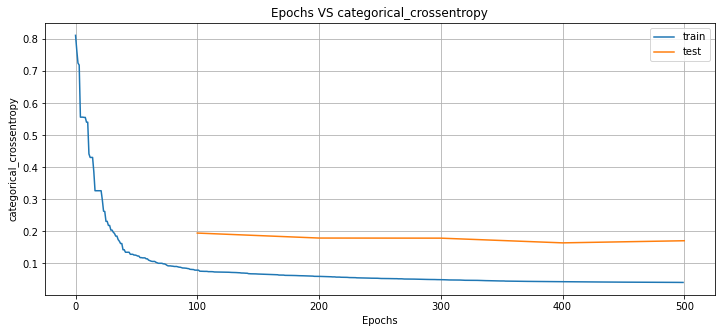

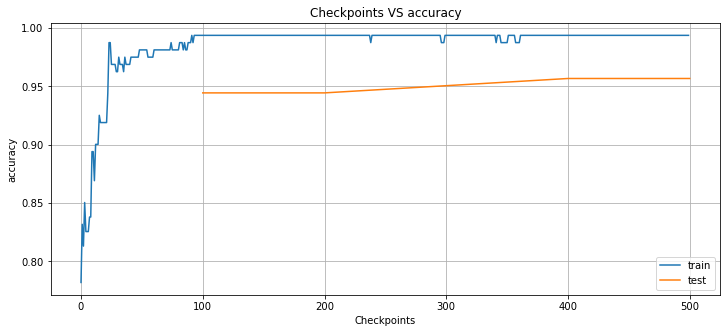

In [15]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [16]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9444444444444444, 'mean_square_error': 0.11409027584267568, 'categorical_crossentropy': 0.19492053985595703, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 5, 'tn_hit': 25, 'fn_hit': 4}, 1: {'tp_hit': 15, 'fp_hit': 4, 'tn_hit': 88, 'fn_hit': 1}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.9444444444444444, 'mean_square_error': 0.10781574755990896, 'categorical_crossentropy': 0.17937216935334382, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 6}, 1: {'tp_hit': 15, 'fp_hit': 5, 'tn_hit': 87, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.11081515828892315, 'categorical_crossentropy': 0.1790390897680212, 'precis

In [17]:
print(model)

Layer 1
Neuron 0: weights:
[ 2.1592987 -3.        -3.        -0.9181153  2.048019 ]
 bias: 2.6750597953796387

Neuron 1: weights:
[ 0.14179704 -3.          0.06468707  1.5987577   3.        ]
 bias: -2.1637089252471924

Neuron 2: weights:
[-1.2146876   2.431537    3.         -0.16768058 -1.9205536 ]
 bias: -1.2749409675598145

Neuron 3: weights:
[-1.42883    1.753719   1.9967005  3.         3.       ]
 bias: 0.15431511402130127

$
Layer 2
Neuron 0: weights:
[ 1.7491548 -3.        -1.7361376 -3.       ]
 bias: 2.0648770332336426

Neuron 1: weights:
[-2.9904478 -1.3063715  3.         3.       ]
 bias: -2.0773837566375732

Neuron 2: weights:
[ 1.4537799  3.        -3.         0.8761022]
 bias: -2.60115122795105

$

